In [8]:
# !pip3 install matplotlib
# !pip3 install sklearn
# !pip3 install tensorflow
# !pip3 install pandas
!pip3 install imgaug
# !pip3 install opencv-python

  Using cached imgaug-0.4.0-py2.py3-none-any.whl (948 kB)
     |████████████████████████████████| 13.1 MB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 574 kB/s eta 0:00:01
  Using cached networkx-2.6.3-py3-none-any.whl (1.9 MB)
  Using cached tifffile-2021.11.2-py3-none-any.whl (178 kB)


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense, Conv2D
import cv2
import pandas as pd
import ntpath
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from imgaug import augmenters as iaa

In [4]:
datadir = 'track'
columns=['center', 'left','right', 'steering','thottle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir,'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth', -1)  # None=> show whole column name, '-1' or 'None'
data.head()

In [5]:
# display only file name without path
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail
data['center']=data['center'].apply(path_leaf)
data['left']=data['left'].apply(path_leaf)
data['right']=data['right'].apply(path_leaf)
data.head()

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


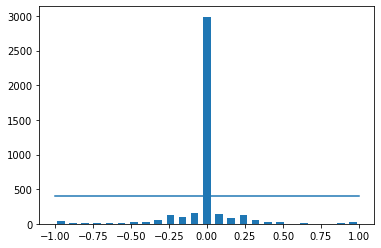

In [15]:
num_bins=25
samples_per_bin =400
hist, bins = np.histogram(data['steering'], num_bins)
center=(bins[:-1]+bins[1:])*0.5 #make it 25 elements, with center at 1
# print(hist)
print(bins) # 26 element
# print(center) 
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin, samples_per_bin))


total data:  4053
removed:  2590
remaining:  1463


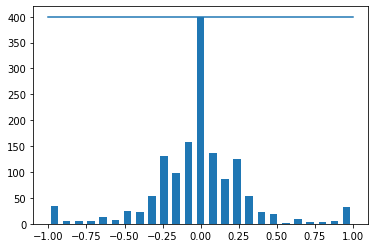

In [17]:
print('total data: ', len(data))
remove_list=[]

for j in range(num_bins):
    list_temp=[]
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i]<= bins[j+1]:
            list_temp.append(i)
 
    list_temp = shuffle(list_temp)
    list_temp=list_temp[samples_per_bin:] # store items going to be remove (only keep the first 'sample_per_bins')
    remove_list.extend(list_temp) # update items going to be removed
    
print("removed: ", len(remove_list))
data.drop(data.index[remove_list], inplace=True) # remove data stored in 'move_list' from original set
print('remaining: ', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))

plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin, samples_per_bin))


In [18]:
print(data.iloc[1])
def load_img_steering(datadir, df):
    image_path =[]
    steering =[]
    for i in range(len(data)):
        indexed_data = data.iloc[i] # '.iloc' the row of data
        center, left, right=indexed_data[0], indexed_data[1],indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings
image_paths, steerings = load_img_steering(datadir+'/IMG',data)

center      center_2018_07_16_17_11_44_413.jpg
left        left_2018_07_16_17_11_44_413.jpg  
right       right_2018_07_16_17_11_44_413.jpg 
steering   -0.05                              
thottle     0.642727                          
reverse     0.0                               
speed       1.434013                          
Name: 12, dtype: object


In [19]:
x_train, x_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(x_train), len(x_valid)))

Training Samples: 1170
Valid Samples: 293


Text(0.5, 1.0, 'Validation set')

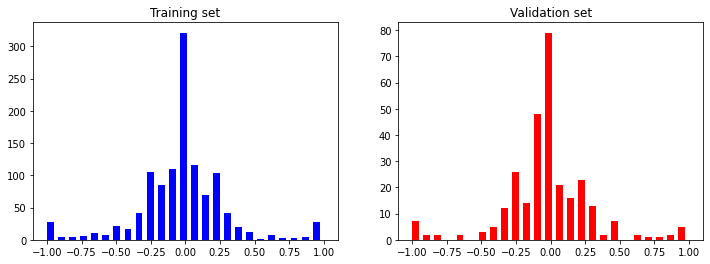

In [20]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')


In [21]:
def zoom(image):
    zoom = iaa.Affine(scale=(1,1.3))
    image = zoom.augment_image(image)
    return image

Text(0.5, 1.0, 'Zoomed Image')

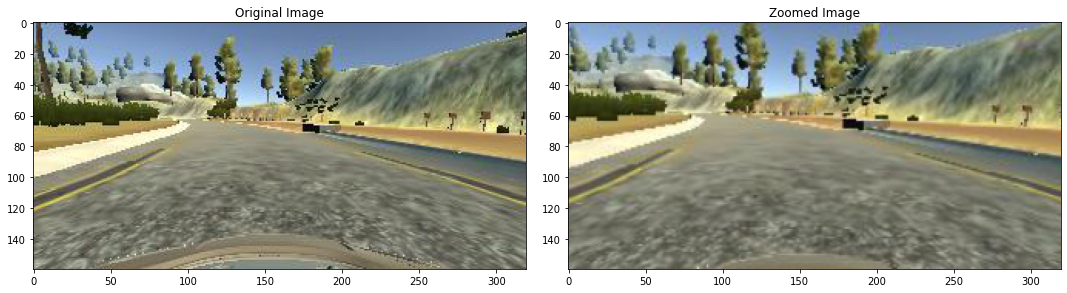

In [22]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

In [23]:
def pan(image):
    pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y":(-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

Text(0.5, 1.0, 'Panned Image')

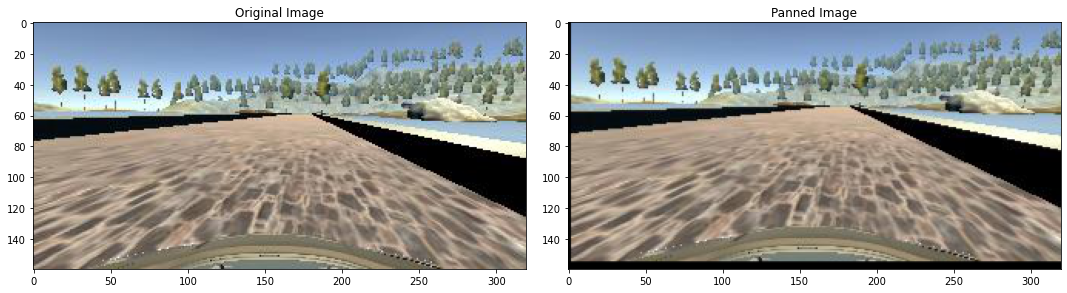

In [24]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

In [25]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

Text(0.5, 1.0, 'Brightness Altered Image')

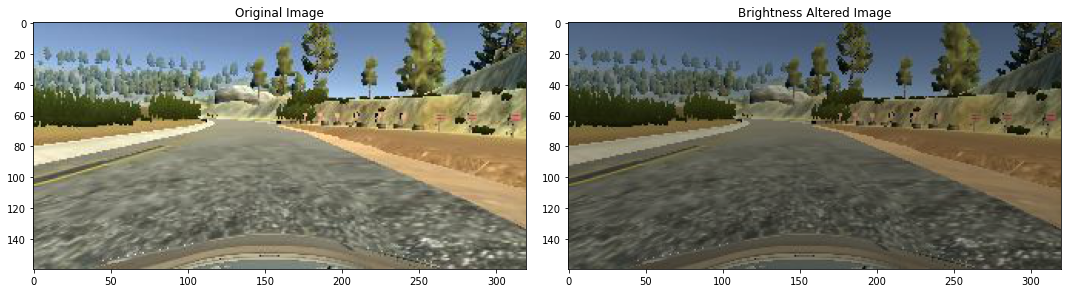

In [26]:
image = image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness Altered Image')

In [27]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image, 1) # 1:horizontal flip, 0: vertical, -1:combinenation
    steering_angle = -steering_angle
    return image, steering_angle
    

Text(0.5, 1.0, 'Flipped Image - steering angle 0.3025817')

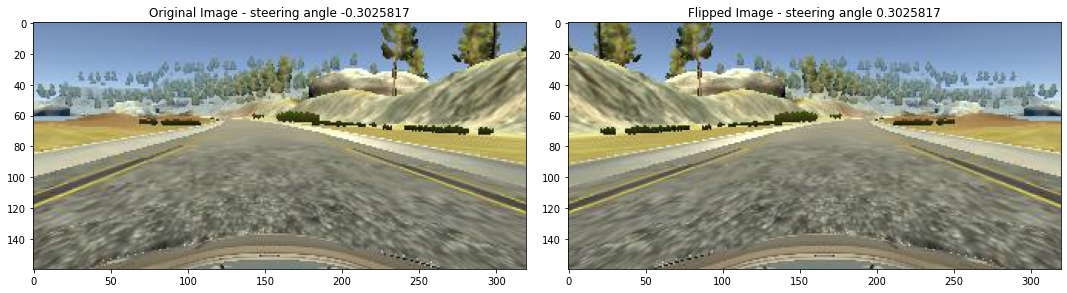

In [28]:
random_index = random.randint(0,1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image,steering_angle )

fig, axs = plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - '+'steering angle '+ str(steering_angle))
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' +'steering angle '+ str(flipped_steering_angle))

In [29]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
        
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(image, steering_angle)
    return image, steering_angle

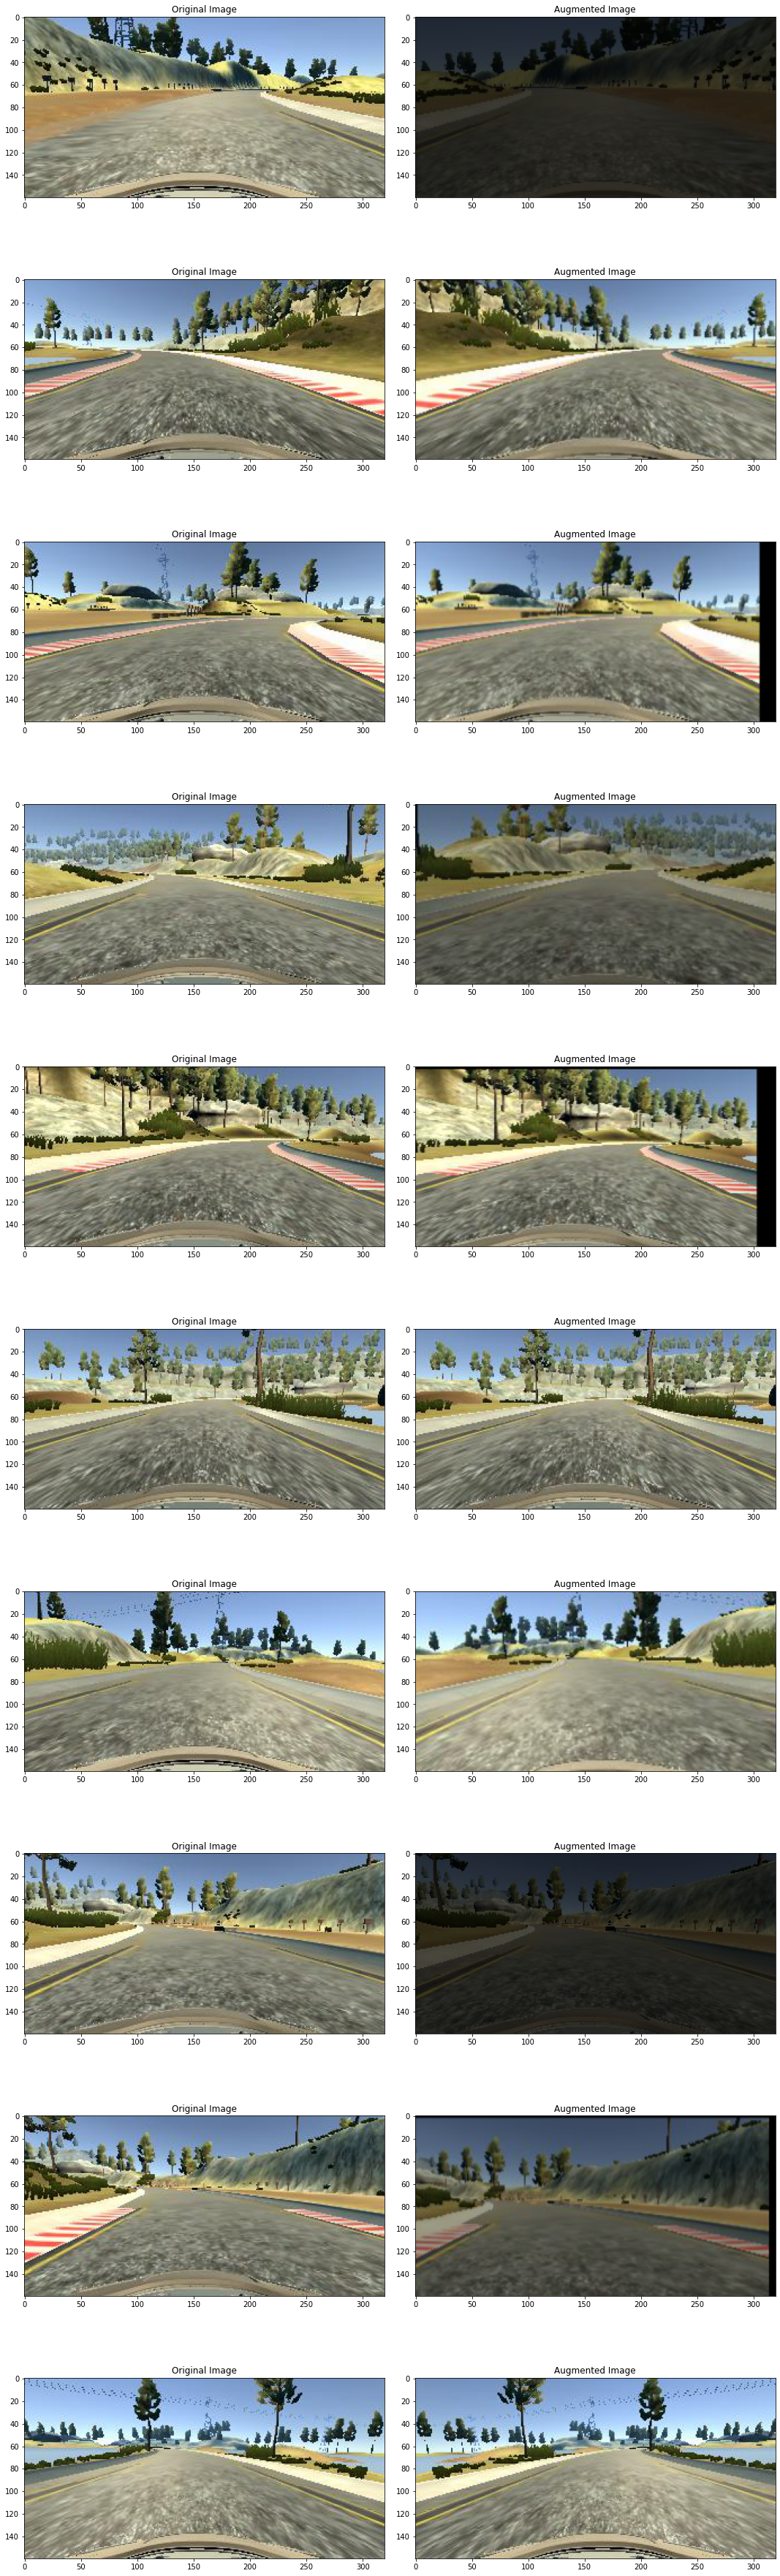

In [30]:
ncol=2
nrow=10
fig, axs = plt.subplots(nrow, ncol, figsize =(15,50))
fig.tight_layout()

for i in range(10):
    randnum = random.randint(0, len(image_paths)-1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]
    
    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)
    
    axs[i][0].imshow(original_image)
    axs[i][0].set_title('Original Image')
    
    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title('Augmented Image')

In [31]:
def img_preprocess(img):
#     img = mpimg.imread(img)
    img = img[60:135, :,: ] # corp image with useful part
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV) # to YUV color which is easily to process
    img = cv2.GaussianBlur(img, (3,3),0) # blur
    img = cv2.resize(img, (200,66))
    img = img/255 # normalize
    return img

Text(0.5, 1.0, 'Preprocessed Image')

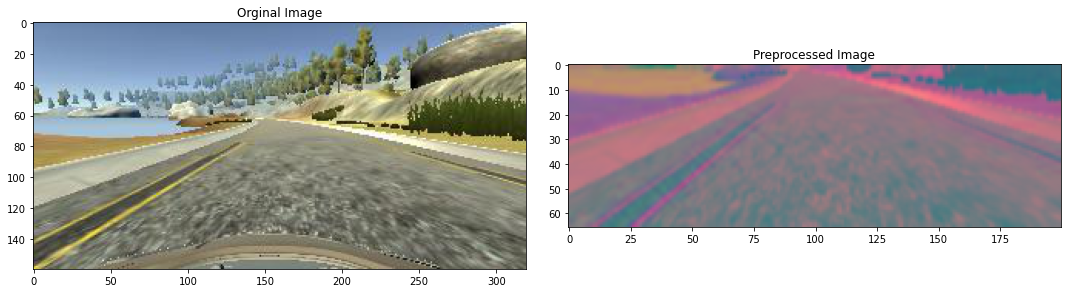

In [32]:
image = image_paths[99]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title("Orginal Image")
axs[1].imshow(preprocessed_image)
axs[1].set_title("Preprocessed Image")




In [33]:
def batch_generator(image_paths, steering_ang, batch_size, intraining):
    while True:
        batch_img =[]
        batch_steering =[]
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) -1)
            
            if intraining: 
                im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
            else: 
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]
            im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1.0, 'Validation Image')

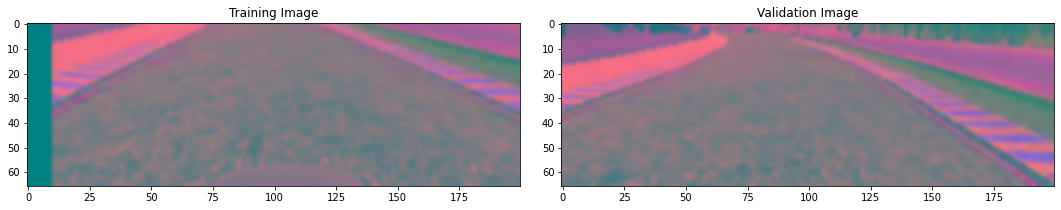

In [34]:
x_train_gen, y_train_gen = next(batch_generator(x_train, y_train, 1,1))
x_valid_gen, y_valid_gen = next(batch_generator(x_valid, y_valid, 1,0))

fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title("Training Image")
axs[1].imshow(x_valid_gen[0])
axs[1].set_title("Validation Image")



In [35]:
# del list # if list was shadowed 
# x_train=np.array(list(map(img_preprocess, x_train)))
# x_valid=np.array(list(map(img_preprocess, x_valid)))


In [36]:
# plt.imshow(x_train[random.randint(0, len(x_train)-1)])
# plt.axis('off')
# print(x_train.shape)


In [37]:
def nvdia_model():
    model = Sequential()
    model.add(Convolution2D(24,(5,5), strides=(2,2), input_shape= (66,200,3), activation ='elu'))
    model.add(Convolution2D(36,(5,5), strides=(2,2), activation ='relu'))
    model.add(Convolution2D(48,(5,5), strides=(2,2), activation ='relu'))
    model.add(Convolution2D(64,(3,3), activation ='relu')) # no need to skip pixels
    
    model.add(Convolution2D(64,(3,3), activation ='relu'))
#     model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(100, activation ='relu'))
#     model.add(Dropout(0.5))
    
    model.add(Dense(50, activation ='relu'))
#     model.add(Dropout(0.5))
    
    model.add(Dense(10, activation ='relu'))
#     model.add(Dropout(0.5))
    
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=1e-4) # low learning rate
    model.compile(loss='mse', optimizer=optimizer)
    return model
    

In [38]:
model = nvdia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)               1

2021-11-05 11:16:56.483711: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/xixi/opt/anaconda3/envs/carEnv/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [40]:
# history = model.fit(x_train, y_train, epochs=30, validation_data=(x_valid, y_valid), batch_size=100, verbose=1, shuffle=1)
history = model.fit_generator(batch_generator(x_train, y_train, 100, 1), 
                              steps_per_epoch=300, 
                              epochs=10, 
                              validation_data = batch_generator(x_valid, y_valid, 100, 0), 
                              validation_steps=200, 
                              verbose=1, 
                              shuffle=1)
                              
   

/var/folders/z_/hxvdn61x2dxcd9zk1lb1sfkc0000gn/T/ipykernel_8159/1500381367.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(batch_generator(x_train, y_train, 100, 1),


Epoch 1/10
300/300 [==============================] - 153s 508ms/step - loss: 0.0759 - val_loss: 0.0491
Epoch 2/10
300/300 [==============================] - 148s 494ms/step - loss: 0.0519 - val_loss: 0.0432
Epoch 3/10
300/300 [==============================] - 147s 490ms/step - loss: 0.0438 - val_loss: 0.0371
Epoch 4/10
300/300 [==============================] - 157s 524ms/step - loss: 0.0411 - val_loss: 0.0303
Epoch 5/10
300/300 [==============================] - 152s 508ms/step - loss: 0.0377 - val_loss: 0.0282
Epoch 6/10
300/300 [==============================] - 149s 497ms/step - loss: 0.0362 - val_loss: 0.0268
Epoch 7/10
300/300 [==============================] - 150s 500ms/step - loss: 0.0338 - val_loss: 0.0265
Epoch 8/10
300/300 [==============================] - 154s 515ms/step - loss: 0.0335 - val_loss: 0.0275
Epoch 9/10
300/300 [==============================] - 152s 508ms/step - loss: 0.0333 - val_loss: 0.0258
Epoch 10/10
300/300 [==============================] - 157s 523m

Text(0.5, 0, 'Epoch')

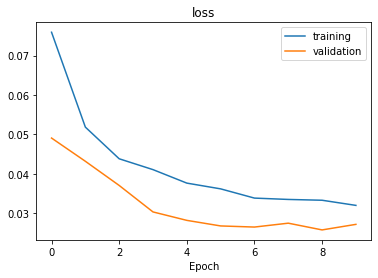

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('Epoch')


In [42]:
model.save('modelf.h5')

In [48]:
!conda install google-colab

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - google-colab

Current channels:

  - https://repo.anaconda.com/pkgs/main/osx-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/osx-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [49]:
from google.colab import files
files.download('modelf.h5')

ModuleNotFoundError: No module named 'google.colab'